In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.imports import *

# Libraries imported
import os
import json 
import shutil
import zipfile

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Setting the path
root_dir = "/home/kaushal/"

# notebook project directories
base_dir = root_dir + 'ml/pcam/'
!mkdir -p "{base_dir}"

In [0]:
# Random seed = 2 was set
np.random.seed(2)

In [7]:
# Instal kaggle so as to download the dataset from kaggle
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
import json
token = {"username":"gagankaushal","key":"b6ee02d1b53b8723e20b5ba45060659a"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!mkdir /root/.kaggle

In [0]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [16]:

# Download the histopathological data
!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}"

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 93.3MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 83.9MB/s]
 99% 1.30G/1.30G [00:33<00:00, 31.3MB/s]
100% 1.30G/1.30G [00:33<00:00, 42.3MB/s]
100% 4.97G/4.98G [00:38<00:00, 134MB/s]
100% 4.98G/4.98G [00:38<00:00, 137MB/s]


In [17]:
# unzip the training files
!mkdir -p "{base_dir}train/"
dest_dir_train = Path(base_dir + 'train/')
print(base_dir + 'train.zip')
train_zip = zipfile.ZipFile(base_dir + 'train.zip', 'r')
train_zip.extractall(dest_dir_train)
train_zip.close()

/home/kaushal/ml/pcam/train.zip


In [0]:
# unzip the test files
!mkdir -p "{base_dir}test/"
dest_dir_test = Path(base_dir + 'test/')
test_zip = zipfile.ZipFile(base_dir + 'test.zip', 'r')
test_zip.extractall(dest_dir_test)
test_zip.close()

In [0]:
dest_dir_csv = Path(base_dir)
labels_csv_zip = zipfile.ZipFile(base_dir + 'train_labels.csv.zip', 'r')
labels_csv_zip.extractall(dest_dir_csv)
labels_csv_zip.close()

In [20]:
# Check the download here
path = Path(base_dir)
path.ls()

[PosixPath('/home/kaushal/ml/pcam/train'),
 PosixPath('/home/kaushal/ml/pcam/train_labels.csv'),
 PosixPath('/home/kaushal/ml/pcam/test.zip'),
 PosixPath('/home/kaushal/ml/pcam/train_labels.csv.zip'),
 PosixPath('/home/kaushal/ml/pcam/test'),
 PosixPath('/home/kaushal/ml/pcam/sample_submission.csv.zip'),
 PosixPath('/home/kaushal/ml/pcam/train.zip')]

In [0]:
tfms = get_transforms(do_flip=True)

In [0]:
bs=64 # also the default batch size
data = ImageDataBunch.from_csv(
    base_dir, 
    ds_tfms=tfms, 
    size=224, 
    suffix=".tif",
    folder="train", 
    test="test",
    csv_labels="train_labels.csv", 
    bs=bs)

In [23]:
# normalise the images
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,1
Path: /home/kaushal/ml/pcam;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,1
Path: /home/kaushal/ml/pcam;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/kaushal/ml/pcam

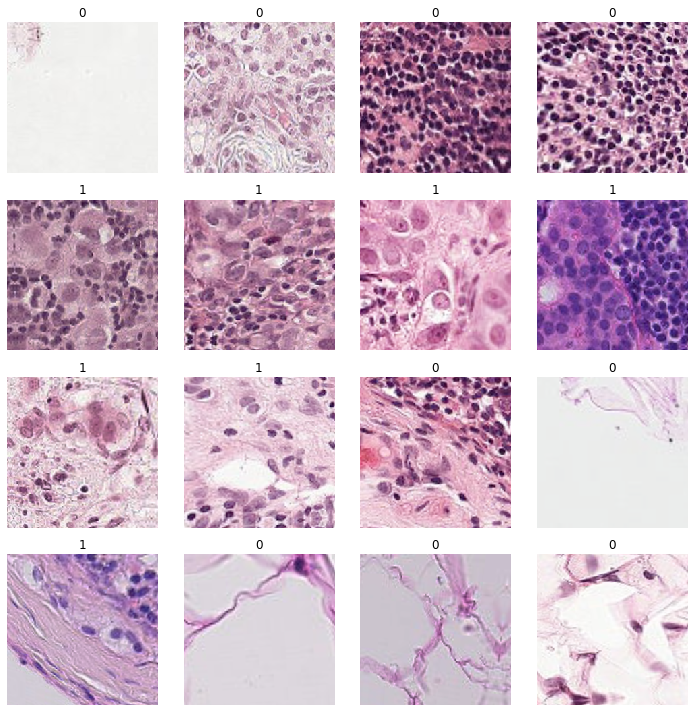

In [24]:
data.show_batch(rows=4, figsize=(10, 10))

In [25]:
# when utilising GPU, mention 'to_fp16()' call, otherwise omit it
learn = cnn_learner(data, models.alexnet, metrics=error_rate, callback_fns=ShowGraph).to_fp16()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:02<00:00, 116MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


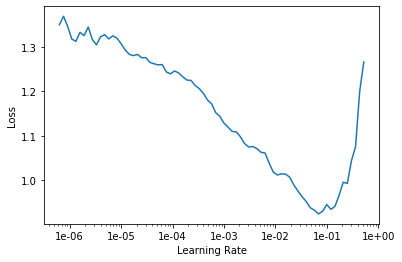

In [26]:
learn.lr_find()
learn.recorder.plot()

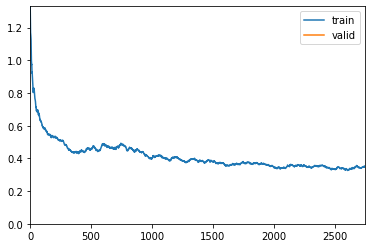

In [27]:
learn.fit_one_cycle(1, slice(1e-02))

In [0]:
learn.save(base_dir + 'alexnet-stage-1')

In [29]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 87.3287124633789 %.


In [30]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

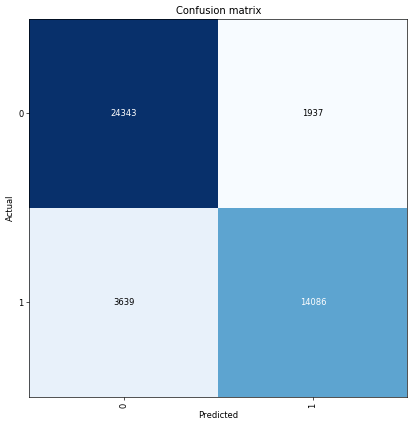

In [31]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

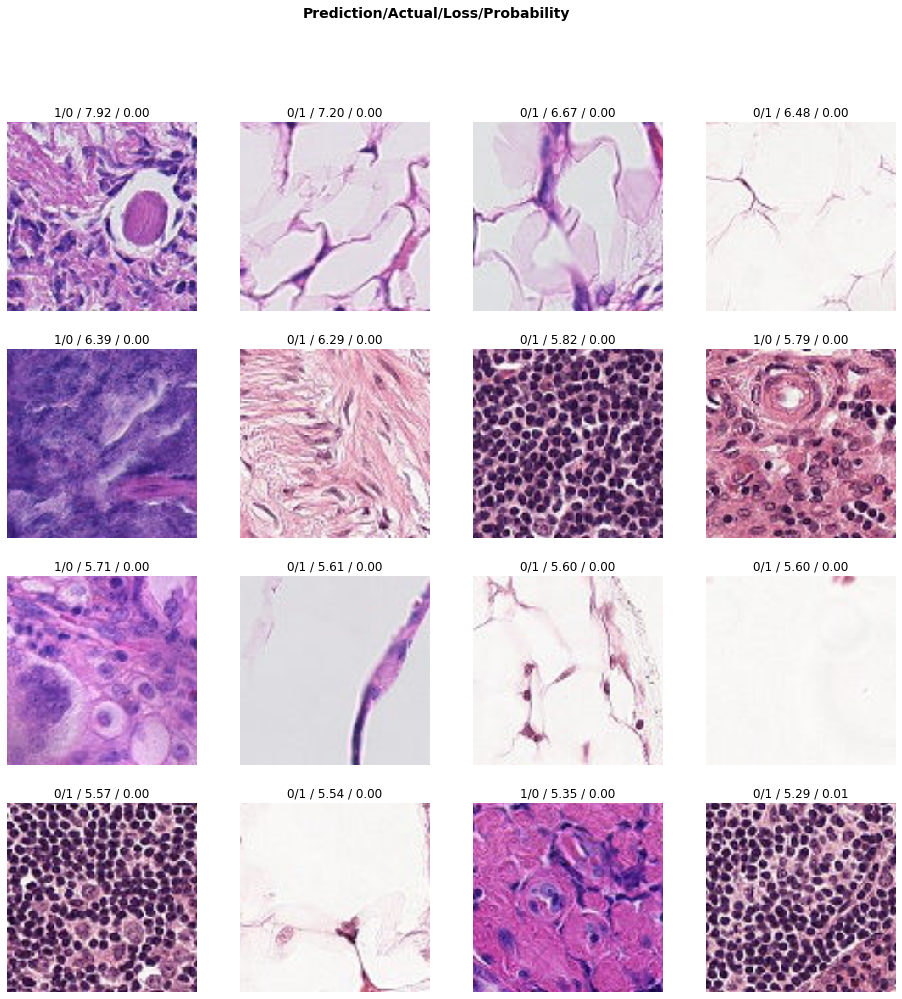

In [32]:
interp.plot_top_losses(16, figsize=(16,16))

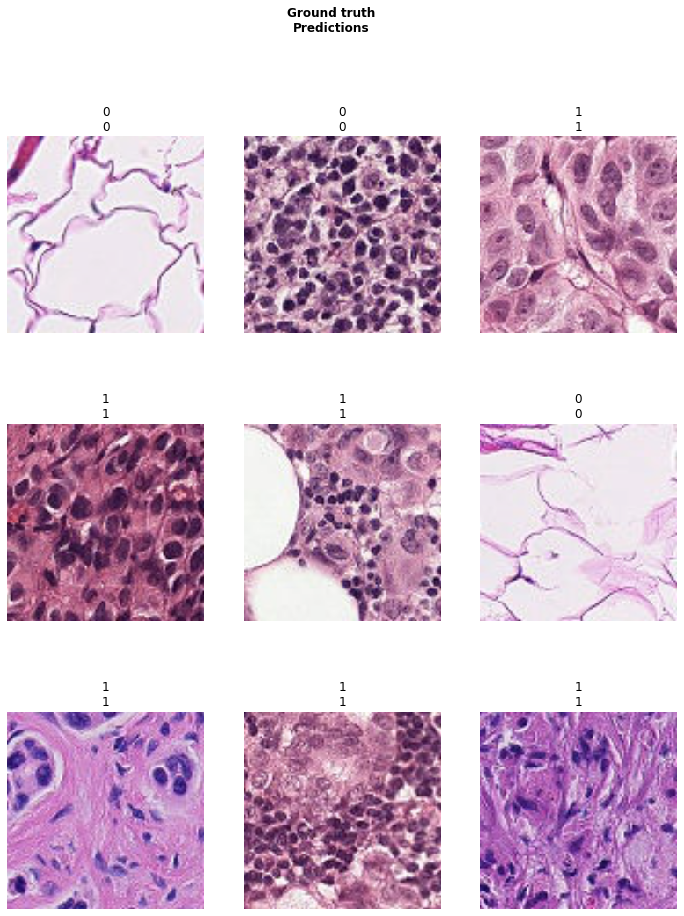

In [33]:
learn.show_results(rows=3, figsize=(12,15))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


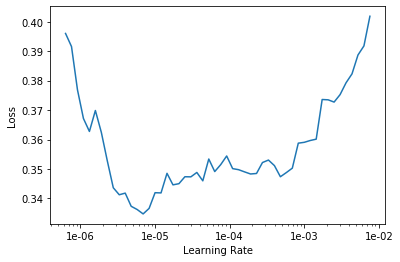

In [34]:
# Using the plot from the learning rate finder above, 
# find a value for the first value in the max_lr slice 
# that is well before the point when the loss start to significantly degrade
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

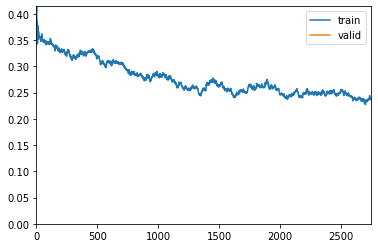

In [35]:

learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-4))

In [36]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 92.10999298095703 %.


In [37]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

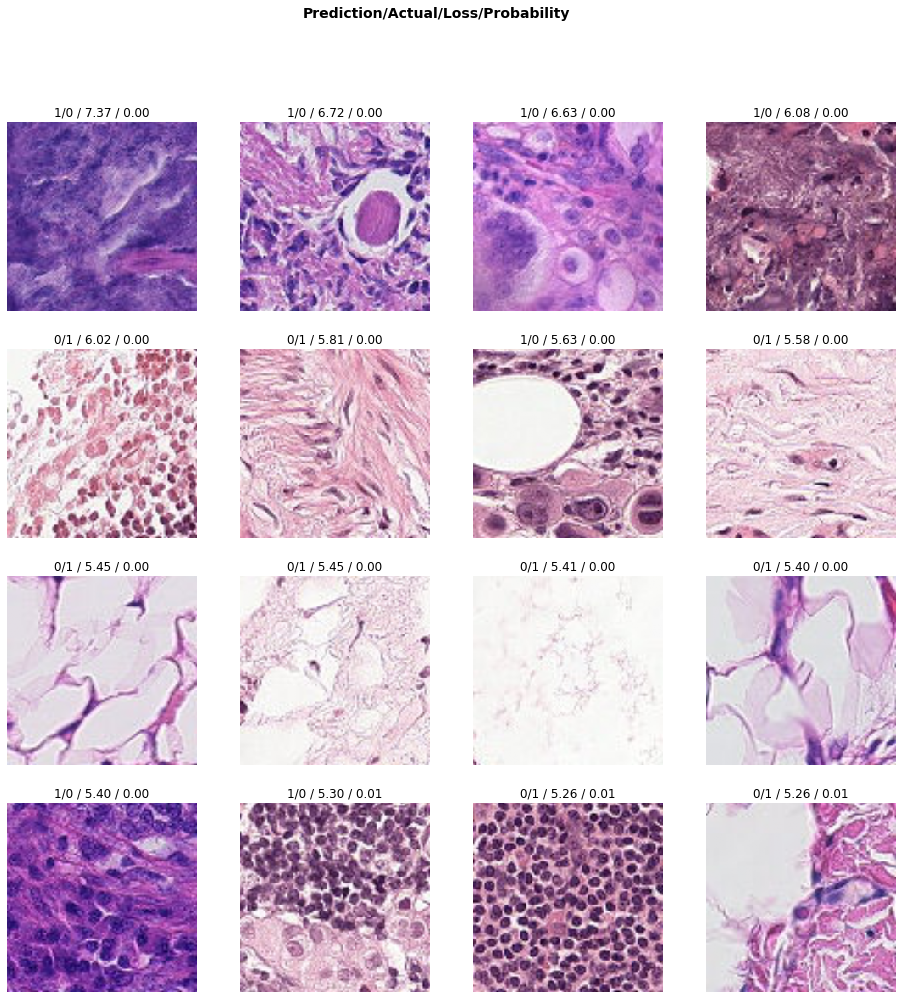

In [38]:
interp.plot_top_losses(16, figsize=(16,16))

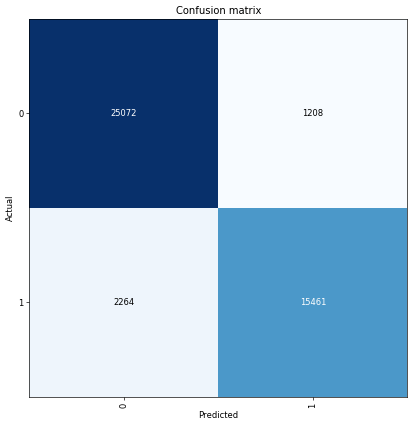

In [39]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)